Using a ACO to learn mywayhome with a static spawn and slightly different deposit parameters as vizdoom_ACO_grid, using the full map converted to a grid as an input space, this was found to be not viable

Import everything

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import math
from torch.utils.tensorboard import SummaryWriter
from vizdoom import * #Import all of vizdoom
import time #To make the program sleep (wait), so we can actually see what's happening
from gymnasium import Env #Import OpenAI Gym's Env class
from gymnasium.spaces import Discrete, Box #Import OpenAI Gym's Discrete and Box spaces
import cv2 #OpenCV for image processing, used for modifying the DOOM environment to make it run faster 
from stable_baselines3.common.callbacks import BaseCallback #Import the BaseCallback class from stable_baselines3 to learn from the environment
from stable_baselines3.common import env_checker #Import the env_checker class from stable_baselines3 to check the environment
import os #To create directories for saving models
import sys #To change the path so we can import the pathfinder module
import matplotlib.pyplot as plt
from collections import deque

original_sys_path = sys.path.copy() #Come back to this path later after we navigate to the parent directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  #Add the parent directory to the path so we can import the pathfinder module
from pathfinder import doomfinder, create_new_best_generation_directory, gamefinder #Import functions from the pathfinder module
sys.path = original_sys_path #Set the path back to the original path

Create a grid with map boundries defined 

In [ ]:
#Map extreme vertices
MIN_X, MAX_X = 160, 1120
MIN_Y, MAX_Y = -704, 128

#Grid dimensions, the map size is actually 960x832
GRID_WIDTH = 960  #1 unit per cell
GRID_HEIGHT = 832  #1 unit per cell

grid_size = (GRID_HEIGHT, GRID_WIDTH)

#Extracted vertices (x, y) coordinates
vertices = [
    (160.000, -256.000), (160.000, -96.000), (320.000, -96.000), (320.000, -144.000),
    (320.000, -256.000), (320.000, -208.000), (544.000, -256.000), (496.000, -256.000),
    (544.000, -96.000), (544.000, -144.000), (384.000, -96.000), (432.000, -96.000),
    (384.000, -256.000), (384.000, -208.000), (544.000, -32.000), (496.000, -32.000),
    (544.000, 128.000), (544.000, 80.000), (384.000, 128.000), (384.000, -32.000),
    (608.000, -256.000), (608.000, -208.000), (768.000, -256.000), (768.000, -96.000),
    (608.000, -96.000), (656.000, -96.000), (608.000, -32.000), (608.000, 16.000),
    (768.000, -32.000), (720.000, -32.000), (768.000, 128.000), (768.000, 80.000),
    (608.000, 128.000), (384.000, -384.000), (432.000, -384.000), (384.000, -544.000),
    (544.000, -544.000), (496.000, -544.000), (544.000, -384.000), (960.000, -32.000),
    (960.000, 16.000), (1120.000, -32.000), (1072.000, -32.000), (1120.000, 128.000),
    (960.000, 128.000), (960.000, -256.000), (960.000, -96.000), (1120.000, -256.000),
    (1088.000, -256.000), (1120.000, -96.000), (1008.000, -96.000), (992.000, -416.000),
    (992.000, -256.000), (1088.000, -416.000), (1072.000, -96.000), (1008.000, -32.000),
    (384.000, -144.000), (848.000, 16.000), (768.000, 16.000), (960.000, 80.000),
    (576.000, 16.000), (544.000, 16.000), (608.000, 80.000), (720.000, -96.000),
    (656.000, -32.000), (496.000, -96.000), (432.000, -32.000), (432.000, -256.000),
    (496.000, -384.000), (432.000, -704.000), (432.000, -544.000), (496.000, -640.000),
    (576.000, -640.000), (576.000, -704.000), (544.000, -208.000), (608.000, -144.000)
]

#Extracted linedefs as pairs of vertex indices
linedefs = [
    (0, 1), (1, 2), (2, 3), (4, 0), (5, 4), (6, 7), (8, 9), (10, 11),
    (12, 13), (14, 15), (16, 17), (18, 16), (19, 18), (20, 21), (22, 20),
    (23, 22), (24, 25), (26, 27), (28, 29), (30, 31), (32, 30), (33, 34),
    (35, 33), (36, 37), (38, 36), (39, 40), (41, 42), (43, 41), (44, 43),
    (45, 46), (47, 48), (49, 47), (46, 50), (51, 52), (53, 51), (48, 53),
    (48, 52), (13, 5), (52, 45), (54, 49), (42, 54), (42, 55), (50, 55),
    (50, 54), (13, 56), (55, 39), (57, 58), (31, 58), (31, 59), (40, 59),
    (40, 57), (58, 28), (59, 44), (60, 61), (17, 61), (17, 62), (27, 62),
    (27, 60), (61, 14), (62, 32), (29, 63), (29, 64), (25, 64), (25, 63),
    (56, 10), (63, 23), (64, 26), (15, 65), (15, 66), (11, 66), (11, 65),
    (3, 5), (65, 8), (66, 19), (67, 12), (34, 67), (34, 68), (7, 68),
    (7, 67), (3, 56), (68, 38), (69, 70), (37, 70), (37, 71), (71, 72),
    (72, 73), (73, 69), (70, 35), (21, 74), (9, 74), (9, 75), (21, 75),
    (75, 24), (74, 6)
]

#Initialize the grid with -1 (outside cells)
starter_grid = np.full(grid_size, -1, dtype=np.float64)

def coord_to_grid(x, y):
    #Convert coordinates to grid indices
    if x < MIN_X or x > MAX_X or y < MIN_Y or y > MAX_Y:
        raise ValueError(f"Coordinates ({x}, {y}) are out of bounds!")
    
    norm_x = (x - MIN_X) / (MAX_X - MIN_X)
    norm_y = (y - MIN_Y) / (MAX_Y - MIN_Y)
    
    grid_x = int(norm_x * (GRID_WIDTH - 1))
    grid_y = int(norm_y * (GRID_HEIGHT - 1))

    return (grid_x, grid_y)

def draw_line(starter_grid, start, end):
    x1, y1 = coord_to_grid(start[0], start[1])
    x2, y2 = coord_to_grid(end[0], end[1])
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    while True:
        starter_grid[y1, x1] = 0  # Mark cell as 0 (inside the linedef)
        if x1 == x2 and y1 == y2:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy


#Draw all lines on the grid
for linedef in linedefs:
    start_vertex = vertices[linedef[0]]
    end_vertex = vertices[linedef[1]]
    draw_line(starter_grid, start_vertex, end_vertex)


#Function to print the grid
def print_grid(starter_grid):
    for row in starter_grid:
        print(' '.join(f'{cell:3}' for cell in row))

#Print the grid to check the result
print_grid(starter_grid)


def flood_fill(starter_grid, start_x, start_y):
    if starter_grid[start_y, start_x] != -1:  # Start only if the cell is not filled or part of the boundary
        return

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    queue = deque([(start_x, start_y)])

    while queue:
        x, y = queue.popleft()

        if starter_grid[y, x] != -1:  # If already visited or is a boundary, skip
            continue

        starter_grid[y, x] = 0  # Fill the cell

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_WIDTH and 0 <= ny < GRID_HEIGHT and starter_grid[ny, nx] == -1:
                queue.append((nx, ny))


insides = [(385, -144), (319, -208), (321, -207), (545, -207), (654, -97), (496, -641), (432, -543), (464, -320), (461, 49), (464, -68),
           (578, 48), (672, -64), (832, 64), (672, 64), (1056, -288), (1024, -160), (1056, -65), (1024, 32)]

for vertex in insides:
    x, y = coord_to_grid(vertex[0], vertex[1])
    flood_fill(starter_grid, x, y)
       

#Plot vertices
plt.figure(figsize=(10, 8))
plt.scatter(*zip(*[coord_to_grid(v[0], v[1]) for v in vertices]), c='blue', label='Vertices')

#Plot lines
for linedef in linedefs:
    start_vertex = vertices[linedef[0]]
    end_vertex = vertices[linedef[1]]
    start_grid = coord_to_grid(start_vertex[0], start_vertex[1])
    end_grid = coord_to_grid(end_vertex[0], end_vertex[1])
    plt.plot([start_grid[0], end_grid[0]], [start_grid[1], end_grid[1]], c='green')

#Create a heatmap to visualize the grid
plt.imshow(starter_grid, cmap='hot', interpolation='nearest')
plt.colorbar(label='Cell Values')
plt.title('Heatmap of Grid with Vertices and Lines')
plt.legend()
plt.show()

def get_starting_grid():
    starter_grid = np.full(grid_size, -1, dtype=np.float64)
    for linedef in linedefs:
        start_vertex = vertices[linedef[0]]
        end_vertex = vertices[linedef[1]]
        draw_line(starter_grid, start_vertex, end_vertex)
    for vertex in insides:
        x, y = coord_to_grid(vertex[0], vertex[1])
        flood_fill(starter_grid, x, y)
    return starter_grid

Define enviornment (for mywayhome)

In [4]:
#Note we are using are representing the map as a 960x832 grid

#Map extreme verticies
MIN_X, MAX_X = 160, 1120
MIN_Y, MAX_Y = -704, 128

#Grid dimensions, the map size is actually 960x832 but this allows us some leeway if we get close to the edge
GRID_WIDTH = 960 #1 unit per cell
GRID_HEIGHT = 832 #1 units per cell

starter_grid = get_starting_grid()

class mywayhome_VZG(Env): #Used for mywayhome config
    def __init__(self, config_path, render=False, grid_size=(GRID_HEIGHT, GRID_WIDTH), pheromone_evaporation_rate=0.001, pheromone_map = None, frameskip = 1): #Constructor
        #Args:
            #config_path (str): The path to the configuration file
            #render (bool): Whether to render the environment or not, false by default
            #grid_size (tuple): The size of the grid (x, y) for the environment
            #pheromone_evaporation_rate (float): The rate at which pheromones evaporate over time
            #pheromone_map (np.array): Optional pre-filled pheromone map, if not provided, it will be initialized with low pheromone levels
            #frameskip (int): The number of frames to skip between actions

        super(mywayhome_VZG, self).__init__() #Inherit from Env class
        
        #Setup game environment
        self.game = vizdoom.DoomGame() #Create a DoomGame object
        self.game.set_doom_game_path(gamefinder('DOOM2.WAD')) #Set the path to the game
        self.game.load_config(config_path) #Load the configuration file from file path
        self.game.set_window_visible(render) #Set window visibility based on render argument
        self.game.init() #Initialize the game
        self.frameskip = frameskip #Set the frameskip

        #Setup action and observation space
        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8) #Observation space, 100x160x1 image, not needed for pathfinding just used for compatibility with stable_baselines3
        self.observation = np.zeros(self.observation_space.shape) #Observation is a blank image
        self.action_space = Discrete(4) #Action space, 4 actions (move forward, move left, move right, move backwards)

        #Grid dimensions and pheromone setup
        self.grid_size = grid_size #Set the grid size as specified 
        if pheromone_map is not None:
            self.pheromone_map = pheromone_map #Use the provided pheromone map if available
        else: #If no pheromone map is provided, initialize a new one
            self.pheromone_map = starter_grid  #Start with adjustable pheromone levels across the gri
        self.pheromone_evaporation_rate = pheromone_evaporation_rate  #Controls how fast pheromones decay over time
        
        #Get game variables
        game_variables = self.game.get_state().game_variables
        xpos, ypos, angle, velocity_x, velocity_y = game_variables #Unpack the game variables
        
        self.xpos = xpos #X position of the player
        self.ypos = ypos #Y position of the player
        self.angle = angle #Angle of the player 
        self.velocity_x = velocity_x #X velocity of the player
        self.velocity_y = velocity_y #Y velocity of the player

    def coord_to_grid(self, x, y): #Convert coordinates to grid indices
        #Args:
            #x (int): X coordinate to convert
            #y (int): Y coordinate to convert
        #Returns:
            #grid_x, grid_y (tuple): The grid indices corresponding to the coordinates
        #Raises:
            #ValueError: If the coordinates are out of bounds

        #Ensure coordinates are within world bounds
        #if x < MIN_X or x > MAX_X or y < MIN_Y or y > MAX_Y:
        #    raise ValueError(f"Coordinates ({x}, {y}) are out of bounds!")
        
        #Normalize coordinates to range [0, 1]
        norm_x = (x - MIN_X) / (MAX_X - MIN_X)
        norm_y = (y - MIN_Y) / (MAX_Y - MIN_Y)
        
        #print(f"norm_x = {norm_x}, norm_y = {norm_y}") #Debug print

        #Scale to grid dimensions and floor the values to ensure integers
        grid_x = int(norm_x * (GRID_WIDTH - 1))
        grid_y = int(norm_y * (GRID_HEIGHT - 1))

        #print(f"grid_x = {grid_x}, grid_y = {grid_y}") #Debug print

        return (grid_x, grid_y)

    def step(self, action, limit = 1000): #Take a step in the environment 
        #Args:
            #action (int): The action to take
            #limit (int): Unimplemented "limit" for the episode, most likely will be a time limit
        #Returns:
            #observation (np.array): The screen buffer of the environment
            #reward (float): The reward for the action taken
            #terminated (bool) Whether the episode is finished or not (by reaching the goal)
            #truncated (bool): Whether the episode has reached some terminal state without reaching the goal (ie: running out of time)
            #info (dict): Additional information about the environment

        #print(f"xpos = {self.xpos}, ypos = {self.ypos}, angle = {self.angle}") #Debug print
        #time.sleep(1) #DEBUG -----------------------------------

        #Specify actions and take a step
        actions = np.identity(4) #Create an identity matrix with 4 rows (4 actions), TURN_LEFT, TURN_RIGHT, MOVE_FOWARD, MOVE_LEFT, MOVE_RIGHT, MOVE_BACKWARD, these are the actions we can take in the environment

        self.game.make_action(actions[action], self.frameskip) #Take an action in the action space, second parameter is frame skip (how many frames we take an action for)
        truncated = False #Not implemented yet, so set to False. The idea is that if step passes some sort of limit, like a time limit, then the episode is truncated.
        info = {"xpos": self.xpos, "ypos": self.ypos, "angle": self.angle, "angle": self.angle, "velocity_x": self.velocity_x, "velocity_y": self.velocity_y} #Initialize info with current position and angle
        reward = 0 #Initialize reward to 0
        
        if self.game.get_state(): #If the game is not finished
            #observation = self.game.get_state().screen_buffer #Get the screen buffer (not needed for pathfinding)
            #observation = self.greyscale(observation) #Convert the image to greyscale
            
            xpos, ypos, angle, velocity_x, velocity_y = self.game.get_state().game_variables #Get the game variables
            self.xpos = xpos #Update the x position
            self.ypos = ypos #Update the y position
            self.angle = angle #Update the angle
            self.velocity_x = velocity_x #Update the x velocity
            self.velocity_y = velocity_y #Update the y velocity

            info = {"xpos": self.xpos, "ypos": self.ypos, "angle": self.angle, "velocity_x": self.velocity_x, "velocity_y": self.velocity_y} #Add position, angle and velocity info to the info dictionary

        #Update pheromones based on movement feedback
            #If this isnt a wall, add pheromones
            #self.pheromone_map[grid_y, grid_x] += 0.1 #Deposit pheromones
            #self.pheromone_map[self.pheromone_map != -1] *= (1 - self.pheromone_evaporation_rate)  #Simulate evaporation, except on walls
            
        terminated = self.game.is_episode_finished() #Check if the episode is finished
        observation = np.zeros(self.observation_space.shape) #Return a blank screen

        return observation, reward, terminated, truncated, info

    def reset(self): #Reset the environment when we start a new game
        #Args:
            #seed (int): The seed for the random number generator
        #Returns:
            #(observation, info) (tuple)
                #observation (np.array): The screen buffer of the environment
                #info (dict): Additional information about the environment
                
        self.game.new_episode() #Start a new episode
        game_variables = self.game.get_state().game_variables  #Get the game variables   
        self.xpos, self.ypos, self.angle, self.velocity_x, self.velocity_y = game_variables  #Unpack the game variables, set agent to its random starting position 

        state = self.game.get_state().screen_buffer
        observation = np.zeros(self.observation_space.shape) #Observation is a blank image
        #observation = self.greyscale(state)  #Convert the initial screen state to greyscale
        info = {"xpos": self.xpos, "ypos": self.ypos, "angle": self.angle, "velocity_x": self.velocity_x, "velocity_y": self.velocity_y} #Add position, angle and velocity info to the info dictionary

        return observation, info  #Return the observation and any additional info

    def greyscale(self, observation): #Convert the environment image to greyscale and resize it
        #Args:
            #observation (np.array): The image of the environment (the current game frame)
        #Returns:
            #grey_return (np.array): The resized greyscale image of the environment
        
        grey = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY) #Convert the image to greyscale
        resize = cv2.resize(grey, (160, 100), interpolation=cv2.INTER_CUBIC) #Resize the image to 160x100 (frame size)
        state = np.reshape(resize, (100, 160, 1)) #Reshape to 100x160x1 for compatibility with neural networks
        
        return state

    def render(self, render_in_greyscale=False): #Render the environment for a frame
        #Args:
            #render_in_greyscale (bool): Whether to render the environment in greyscale or not
        
        if self.game.get_state() and render_in_greyscale:  #Only render if there's a valid game state
            observation = self.game.get_state().screen_buffer
            greyscale_obs = self.greyscale(observation)  #Convert the observation to greyscale
            cv2.imshow("VizDoom Environment", greyscale_obs.squeeze())  #Remove extra dimension and display
            cv2.waitKey(1)  #Wait 1ms between frames to allow for rendering
        elif self.game.get_state():  #Only render if there's a valid game state
            observation = self.game.get_state().screen_buffer
            cv2.imshow("VizDoom Environment", observation.squeeze())  #Render the environment without greyscale
            cv2.waitKey(1)  #Wait 1ms between frames to allow for rendering
        else:
            print("No game state to render.")

    def get_state(self): #Get the current state of the environment
        #Returns:
            #state (np.array): The current state of the environment
        return self.game.get_state()

    def get_agent_position(self): #Get the current position of the agent (tuple of x, y coordinates)
        #Returns:
            #(xpos, ypos) (tuple): The current position of the agent

        return (self.xpos, self.ypos)

    def close(self): #Close the environment when done
        self.game.close()  #Terminate the game

Define Plotting, Saving, and Finding Pheromone Maps

In [5]:
import matplotlib.colors as mcolors

def plot_pheromone_grid(pheromone_grid, title, log_dir, iteration, save_image):
    #Create a custom colormap
    cmap = plt.cm.hot
    cmap = cmap.copy()
    cmap.set_bad(color='blue') #Set color for walls (-1) to black

    #Mask the grid to handle walls (-1)
    masked_grid = np.ma.masked_where(pheromone_grid == -1, pheromone_grid)

    plt.imshow(masked_grid, cmap=cmap, interpolation='nearest')
    plt.title(title)
    plt.colorbar(label="Pheromone Intensity")
    if save_image:
        image_path = os.path.join(log_dir, f"pheromone_grid_iteration_{iteration}.png")
        plt.savefig(image_path)
        print(f"Pheromone grid image saved to {image_path}")
    plt.show()


def create_run_directory(base_dir="aco_runs/grid_aco_mywayhome"): #Create a new run directory for the ACO algorithm
    os.makedirs(base_dir, exist_ok=True)
    existing_runs = [int(d.split('_')[-1]) for d in os.listdir(base_dir) if d.split('_')[-1].isdigit()]
    run_number = max(existing_runs, default=0) + 1
    run_dir = os.path.join(base_dir, f"run_{run_number}")
    os.makedirs(run_dir, exist_ok=True)
    #Create saved maps directory within the run directory
    maps_dir = os.path.join(run_dir, "saved_maps")
    os.makedirs(maps_dir, exist_ok=True)
    #Create log directory within the run directory
    log_dir = os.path.join(run_dir, "log")
    os.makedirs(log_dir, exist_ok=True)
    return run_dir, log_dir, maps_dir

def save_pheromone_grid(pheromone_grid, maps_dir, iteration):
    filename = os.path.join(maps_dir, f"pheromone_grid_iteration_{iteration}.npy")
    np.save(filename, pheromone_grid)
    #print(f"Pheromone grid saved to {filename}")

def load_pheromone_grid(run_dir="aco_runs/grid_aco_mywayhome", run_number=0, filename="pheromone_grid.npy"):
    run_dir = os.path.join(run_dir, f"run_{run_number}/saved_maps")
    filepath = os.path.join(run_dir, filename)
    #print(filepath) #Print the path
    if os.path.exists(filepath):
        pheromone_grid = np.load(filepath)
        #print(f"Pheromone grid loaded from {filepath}")
        return pheromone_grid
    else:
        #print(f"No saved pheromone grid found at {filepath}")
        return None

Define Training

In [25]:
def aco_training(env, num_ants=10, iterations=50, alpha=0.6, beta=0.4, pheromone_deposit=2.0, unsuccessful_deposit=0.1, run_dir="aco_runs/grid_aco_mywayhome", log_dir = "aco_runs/grid_aco_mywayhome/run_x/log", maps_dir = "aco_runs/grid_aco_mywayhome/run_x/saved_maps", distance_weight = 0.7, time_weight = 0.3, save_rate = 20, log_image_rate = 5): #Train the ACO algorithm in the ViZDoom environment
    """
    Train a bot to pathfind in the ViZDoom environment using ACO.
    
    Args:
        env (Env): The ViZDoom environment.
        num_ants (int): Number of ants (pathfinding agents) per iteration.
        iterations (int): Total iterations for ACO.
        alpha (float): Importance of pheromones.
        beta (float): Importance of heuristic (distance to goal).
        pheromone_deposit (float): Amount of pheromone deposited on successful paths.
        unsuccessful_deposit (float): Amount of pheromone deposited on unsuccessful paths.
        run_dir (str): Directory to save the ACO run data.
        log_dir (str): Directory to save logs and images.
        maps_dir (str): Directory to save pheromone maps.
        distance_weight (float): Weight for distance factor in pheromone update.
        time_weight (float): Weight for time factor in pheromone update.   
        save_rate (int): Rate at which to log sucess counts.
        log_image_rate (int): Rate at which to log pheromone grid images.
        """
    #Initialize pheromone grid
    pheromone_grid = env.pheromone_map
    
    frameskip = env.frameskip #Get the frameskip from the environment

    #Normalize alpha and beta to ensure they add up to 1
    total_weight = alpha + beta
    alpha /= total_weight
    beta /= total_weight

    #Generate list of goal positions
    #GOAL_POSITIONS = [env.coord_to_grid(x, y) for x in range(1008, 1072) for y in range(-324, -315)] 

    GOAL_POSITION = (1045, -316) #We simplify from a list of goal positions to one goal position because 
    #having a list of goal positions causes the agent to get stuck in a loop where it keeps going back and forth 
    #between the goal positions different equal minimum distances, which weakens the hueristic function, this 
    #position will always trigger the end of the episode

    #Heuristic function: inverse distance to the goal
    def heuristic(x, y):
        gx, gy = GOAL_POSITION
        distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)
        return 1.0 / (distance + 1e-6)

    #Simulate movement locally without stepping the game, this is not 100% accurate but it's a good approximation
    def simulate_move(x, y, angle, velocity_x, velocity_y, move):

        friction = 0.90625  #Doom's friction factor
        step_size = env.frameskip  #Approximate movement step size
        angle_rad = np.deg2rad(angle)  #Convert angle to radians

        for step in range(step_size):
            if move == 0:  #MOVE_FORWARD
                velocity_x += np.cos(angle_rad)
                velocity_y += np.sin(angle_rad)
            elif move == 1:  #MOVE_LEFT
                velocity_x -= np.sin(angle_rad)
                velocity_y += np.cos(angle_rad)
            elif move == 2:  #MOVE_RIGHT
                velocity_x += np.sin(angle_rad)
                velocity_y -= np.cos(angle_rad)
            elif move == 3:  #MOVE_BACKWARD
                velocity_x -= np.cos(angle_rad)
                velocity_y -= np.sin(angle_rad)

            #Apply friction to velocities
            velocity_x *= friction
            velocity_y *= friction

            #Update positions based on the updated velocities
            x += velocity_x
            y += velocity_y

            x = np.clip(x, MIN_X+1, MAX_X-1)  #We might have gone out of bounds, so clip the x position
            y = np.clip(y, MIN_Y+1, MAX_Y-1)  #We might have gone out of bounds, so clip the y position

            #Convert the new position to grid indices
            grid_x, grid_y = env.coord_to_grid(x, y)

            #Check if the new position is a wall
            if env.pheromone_map[grid_y, grid_x] == -1:
                #If a wall is encountered, backtrack to the last valid position
                while env.pheromone_map[grid_y, grid_x] == -1:
                    x -= velocity_x
                    y -= velocity_y
                    x = np.clip(x, MIN_X + 1, MAX_X - 1)
                    y = np.clip(y, MIN_Y + 1, MAX_Y - 1)
                    grid_x, grid_y = env.coord_to_grid(x, y)
                break
        
        return x, y

    #BANDAID FIX: WILL FIGURE THIS OUT LATER, RIGHT NOW SIMULATE NEXT MOVE WITH FRICTION CRASHES THE ENV RANDOMLY, THIS IS THE OLD SELECT NEXT MOVE CODE
    #Simulate movement locally without stepping the game
    #def simulate_move(x, y, angle, velocity_x, velocity_y, move):   
    #    #print(f"x passed is {x}, y passed is {y}")  #Debug print
    #
    #    step_size = env.frameskip  #Approximate movement step size, this varies HEAVILY based on momentum and such, not sure how to get an accurate approximation each time
    #    angle_rad = np.deg2rad(angle)  #Convert angle to radians
    #
    #    if move == 0:  #MOVE_FORWARD
    #        new_x = x + step_size * (np.cos(angle_rad) + velocity_x)
    #        new_y = y + step_size * (np.sin(angle_rad) + velocity_y)
    #    elif move == 1:  #MOVE_LEFT
    #        new_x = x - step_size * (np.sin(angle_rad) + velocity_x)
    #        new_y = y + step_size * (np.cos(angle_rad) + velocity_y)
    #    elif move == 2:  #MOVE_RIGHT
    #        new_x = x + step_size * (np.sin(angle_rad) + velocity_x)
    #        new_y = y - step_size * (np.cos(angle_rad) + velocity_y)
    #    elif move == 3:  #MOVE_BACKWARD
    #        new_x = x - step_size * (np.cos(angle_rad) + velocity_x)
    #        new_y = y - step_size * (np.sin(angle_rad) + velocity_y)
    #    else:
    #        new_x, new_y = x, y
    #
    #    return new_x, new_y

    #Function to select next move based on pheromones and heuristic
    def select_next_move(x, y, velocity_x, velocity_y, angle):
        possible_moves = [0, 1, 2, 3]  #MOVE_FORWARD, MOVE_LEFT, MOVE_RIGHT, MOVE_BACKWARD
        probs = []
        backup_probs = [] #Saves probabilities incase all moves have already been taken
        valid_moves = [] #List of valid moves
        pheromone_values = [] #List of pheromone values in the possible moves
        eta_values = [] #List of heuristic values in the possible moves
        distances = [] #List of distances to the goal for each move
         
        for move in possible_moves:
            #Simulate movement locally without stepping the game
            #walls_detected = []
            simulated_x, simulated_y = simulate_move(x, y, angle, velocity_x, velocity_y, move)
            #print(f"Simulated move: {move}, x: {simulated_x}, y: {simulated_y}, angle: {simulated_angle}")  #Debug print

            #Convert to grid indices and calculate pheromone + heuristic
            grid_x, grid_y = env.coord_to_grid(simulated_x, simulated_y)
            if 0 <= grid_x < GRID_WIDTH and 0 <= grid_y < GRID_HEIGHT:
                pheromone = pheromone_grid[grid_y, grid_x]
                if pheromone >= 0: #If the move is not into a wall
                    if pheromone == 0: #If the pheromone level is 0, set a small value to avoid division by zero
                        pheromone = 1.0e-16 
                    eta = heuristic(grid_x, grid_y)
                    distance = np.sqrt((GOAL_POSITION[0] - grid_x) ** 2 + (GOAL_POSITION[1] - grid_y) ** 2)
                    #print(f"eta = {eta}, pheromone = {pheromone}")
                    pheromone_values.append(pheromone)
                    eta_values.append(eta)
                    distances.append(distance)
                    valid_moves.append((move, grid_x, grid_y)) #Add the move to the list of valid moves
                #else:
                    #print(f"Wall detected, so I wont move to {env.coord_to_grid(simulated_x, simulated_y)}")  #Debug print
                    #walls_detected.append(move)

        if not valid_moves:
            #print("No valid moves available. Selecting a random move.")
            return np.random.choice(possible_moves)

        max_pheromone = np.max(pheromone_values) #Get the maximum pheromone level
        max_eta = np.max(eta_values) #Get the maximum eta value

        #Rank the moves based on distance to the goal
        sorted_indices = np.argsort(distances)
        valid_moves = [valid_moves[i] for i in sorted_indices]
        rank_adjustments = np.zeros(len(valid_moves))
        adjustment_values = [1.0, 0.75, 0.5, 0.25]  #The move closest to the goal gets the highest boost, the farthest gets the lowest
        #adjustment_values = [1.0, 0.0, 0.0, 0.0]  #For testing, only choose best move
        moves_considered = []

        #print(f"Sorted indices: {sorted_indices}")
        #print(f"Valid moves: {valid_moves}") #Debug print, check to see if the moves are sorted correctly

        rank = 0 #Start at rank 0
        for i in range(len(sorted_indices)): #Iterate through the sorted indices
            if i > 0 and distances[sorted_indices[i]] != distances[sorted_indices[i-1]]: #If the distance is different from the previous distance
                rank += 1 #Increment the rank 
            if rank < len(adjustment_values): #If the rank is less than the number of boost values
                rank_adjustments[sorted_indices[i]] = adjustment_values[rank] #Set the rank boost value
            else:
                rank_adjustments[sorted_indices[i]] = 0.0 #Otherwise, set the rank boost to 0

        for i, (move, grid_x, grid_y) in enumerate(valid_moves):
            pheromone = pheromone_grid[grid_y, grid_x]

            eta = heuristic(grid_x, grid_y)
            #Normalize pheromone and heuristic values
            norm_pheromone = pheromone / max_pheromone
            norm_eta = eta / max_eta  
            #print(f"Norm pheromone: {norm_pheromone}, norm eta: {norm_eta}, for move: {move}, ({grid_x}, {grid_y})")
            #print(f"Adjusted pheremone value: {norm_pheromone * alpha}, adjusted eta value: {beta * (norm_eta * adjustment_values[i])}, for move: {move}, ({grid_x}, {grid_y})")
            prob = alpha * norm_pheromone + beta * (norm_eta * adjustment_values[i]) #Alpha and beta contriubte to the probability
            #prob = (norm_pheromone ** alpha) * (norm_eta ** (beta * (adjustment_values[i]))) #Boost the probability based on rank

            #print(f"Adjusted beta eta value: {beta * (adjustment_values[i])}")  #Debug print
            
            if (grid_x, grid_y) in path or (grid_x, grid_y) in choices_made:
                probs.append(0)  #Set probability to zero if the move has already been made
                backup_probs.append(prob) 
            else:
                probs.append(prob)
                backup_probs.append(prob)
                #print(f"Move considered: {move}, ({grid_x}, {grid_y}), prob: {prob}") 
                moves_considered.append((move, grid_x, grid_y)) #Add the move to the list of moves considered
                #if path and choices_made:
                    #print(f"By adding this, we break the path rule: {(grid_x, grid_y) in path}, and the choices made rule, {(grid_x, grid_y) in choices_made}")
                    #print(f"And I'm totally not lying and I can prove it by saying that the choice we made is {(grid_x, grid_y)} and path[-1] is {path[-1]} and choices_made[-1] is {choices_made[-1]}")

            #print(f"Move: {move}, pheromone: {pheromone}, eta: {eta}, norm_pheromone: {norm_pheromone}, norm_eta: {norm_eta}")

        #Normalize probabilities
        probs = np.array(probs)
        backup_probs = np.array(backup_probs)
        choice_index = -1

        #Disable backup probs if you get stuck
        if probs.sum() == 0: #and backup_probs.sum() == 0:
            probs = np.ones(len(valid_moves)) / len(valid_moves)  #Equal probability
            choice_index = np.random.choice(len(valid_moves), p=probs)
        #elif probs.sum() == 0: #If all possible moves have been made
        #    probs = backup_probs / backup_probs.sum() #Normalize probabilities
        #    choice_index = np.random.choice(len(valid_moves), p=probs)
        else:
            probs /= probs.sum() #Normalize probabilities
            choice_index = np.random.choice(len(valid_moves), p=probs)
        
        #if moves_considered:
        #    for move, p in zip (moves_considered, probs): #Print moves and their probabilities
        #        print(f"move {move} prob {p}")
        #else:
        #    for move, p in zip (valid_moves, probs): #Print moves and their probabilities
        #        print(f"move {move} prob {p}")
        
        choice, choice_x, choice_y = valid_moves[choice_index]
        
        #if len(path) > 1 and len(choices_made) > 1:
        #    #Check if (choice_x, choice_y) is in path excluding the last entry
        #    path_excluding_last = path[:-1]
        #    choices_made_excluding_last = choices_made[:-1]
        #    
        #    broke_path_rule = (choice_x, choice_y) in path_excluding_last
        #    broke_choices_made_rule = (choice_x, choice_y) in choices_made_excluding_last
        #    
        #    print(f"We broke the path rule, {broke_path_rule}, We broke the choices made rule, {broke_choices_made_rule}")
        #    print(f"And I'm totally not lying and I can prove it by saying that the choice we made is {(choice_x, choice_y)} and path[-1] is {path[-1]} and choices_made[-1] is {choices_made[-1]}")


        choices_made.append((choice_x, choice_y)) #Add where we THINK we are going to the list oc choices made,
        #this is due to the fact that the select next move function doesnt always calculate 
        #the position correctly, so we add this position so we no longer try and make this move in the future 
        
        #print(f"Choices made {choices_made}") #Print the choices made so far

        #print(f"Moves considered: {moves_considered}")
        #print(f"Valid moves: {valid_moves}")
        #print(f"Choice made: {choice}, ({choice_x}, {choice_y})")

        #This seems to not happen ever so thats good
        #if choice in walls_detected:
            #print("I ran into a wall for some reason.")
            #time.sleep(2) #Sleep for 2 seconds, so we can see what happened

        return choice
    
    #Define boundaries for classifying spawn locations
    def classify_spawn(x, y):
        gx, gy = GOAL_POSITION
        distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)
        #print(f"Distance to goal: {distance}")
        if distance > 600:  # Example threshold for "far"
            return "far"
        elif distance > 400:  #Spawned in the middle of the map
            return "relatively close"
        else:  
            return "close" #Spawned in the corder facing the goal

    #Function to check if a point is adjacent to a wall
    #def is_adjacent_to_wall(grid, x, y):
    #    adjacent_offsets = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    #    for dx, dy in adjacent_offsets:
    #        adj_x, adj_y = x + dx, y + dy
    #        if 0 <= adj_x < grid.shape[1] and 0 <= adj_y < grid.shape[0]:
    #            if grid[adj_y, adj_x] == -1:
    #                return True
    #    return False

    #Main ACO loop
    
    checkpoint = 0 #Where we are at in sucess rates logging

    #Create the "success_rates" folder if it doesn't exist
    success_rates_dir = os.path.join(run_dir, "success_rates")
    os.makedirs(success_rates_dir, exist_ok=True)

    plot_pheromone_grid(pheromone_grid, "Initial Grid", log_dir, 0, save_image=False) #Plot the pheromone grid after each ant
    #Initialize running tally dictionaries
    total_success_counts = {
        "far": 0,
        "relatively close": 0,
        "close": 0
    }
    total_spawn_counts = {
        "far": 0,
        "relatively close": 0,
        "close": 0
    }

    stored_spawn_counts = [] #List to store spawn counts, wiped after each log
    stored_success_counts = [] #List to store spawn counts, wiped after each log

    #Open the file to save the success counts
    success_file_path = os.path.join(run_dir, "success_counts.txt")
    
    for iteration in range(iterations): 
        print(f"Iteration {iteration + 1}/{iterations}")

        #Initialize counters for successful ants and spawn counts
        success_counts = {
            "far": 0,
            "relatively close": 0,
            "close": 0
        }
        spawn_counts = {
            "far": 0,
            "relatively close": 0,
            "close": 0
        }

        #List to store paths and pheromone deposits for each ant
        ant_paths = []
        ant_deposits = []

        for ant in range(num_ants):

            terminated = False
            tics = 10 #Start at 10 tics

            observation, info = env.reset()
            x, y, angle, x_velocity, y_velocity = env.xpos, env.ypos, env.angle, env.velocity_x, env.velocity_y #Get the initial position and velocity of the ant
            path = []
            choices_made = [] #List of choices made by the ant
            success = False
            spawn_classification = classify_spawn(x, y) #We spawned in this area
            spawn_counts[spawn_classification] += 1  #Increment the spawn counter

            #Calculate initial distance to the closest goal
            gx, gy = GOAL_POSITION
            initial_distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)
            max_distance = np.sqrt(GRID_WIDTH ** 2 + GRID_HEIGHT ** 2)  #Maximum possible distance in the environment
            distance_factor = initial_distance / max_distance  #Normalize the distance factor

            while not terminated:  #Steps are limited to number of tics (2100) by the config
                action = select_next_move(x, y, x_velocity, y_velocity, angle)
                observation, _, terminated, _, info = env.step(action)
                x, y, angle = info['xpos'], info['ypos'], info['angle']

                converted_x, converted_y = env.coord_to_grid(x, y) #Convert the position to grid indices

                #Interpolate missing points in real-time
                if path:
                    last_x, last_y = path[-1]
                    dx = converted_x - last_x
                    dy = converted_y - last_y
                    steps = int(max(abs(dx), abs(dy)))  #Convert steps to an integer
                    if steps > 1:  #Interpolate the missing points
                        for step in range(1, steps):
                            interpolated_x = round(last_x + step * dx / steps)
                            interpolated_y = round(last_y + step * dy / steps)
                            path.append((interpolated_x, interpolated_y))

                tics = tics + 1 * frameskip #Increment tics, multiply by frameskip to account for the frameskip
                
                path.append((converted_x, converted_y)) #Add the current position to the path

            if tics < 2100: #If the ant reached the goal
                print(f"Ant {ant} reached the goal in {tics} steps.")
                success = True
                success_counts[spawn_classification] += 1 

            #Store the path and pheromone deposit value for this ant
            ant_paths.append(path)
            ant_deposits.append((success, tics, distance_factor))

            print(f"Ant {iteration}.{ant}, tics: {tics}, success: {success}")
            print(f"Path: {path}")
            #plot_pheromone_grid(pheromone_grid, (f"Pheromone Grid After Ant {iteration}.{ant}"), log_dir, iteration, save_image=False) #Plot the pheromone grid after each ant

        #Evaporate pheromones
        pheromone_grid[pheromone_grid != -1] *= (1 - env.pheromone_evaporation_rate)  #Do evaporation after ant instead of in env
        #pheromone_grid[pheromone_grid != -1] = np.maximum(0, pheromone_grid[pheromone_grid != -1] - env.pheromone_evaporation_rate) #Subtract pheremones directly instead of percentage based evaporation rate

        #Apply pheromones
        for path, (success, tics, distance_factor) in zip(ant_paths, ant_deposits):
            visited_points = set()
            if success:
                for (px, py) in path: #Give a little boost to path if the ant reached the goal
                    #if (px, py) not in visited_points and pheromone_grid[py, px] != -1 and not is_adjacent_to_wall(pheromone_grid, px, py):  #If the point has not been visited, is not a wall, and is not adjacent to a wall
                    if (px, py) not in visited_points and pheromone_grid[py, px] != -1:  #If the point has not been visited and is not a wall
                        visited_points.add((px, py))
                        time_factor = 1.0 / (tics + 1e-6)  #Inverse of the number of tics taken
                        combined_weight = distance_factor * distance_weight + time_factor * time_weight  #Prioritize distance factor
                        pheromone_grid[py, px] += pheromone_deposit * combined_weight
                        #print(combined_weight*pheromone_deposit)
            else:
                for (px, py) in path:
                    #if (px, py) not in visited_points and pheromone_grid[py, px] != -1 and not is_adjacent_to_wall(pheromone_grid, px, py):  #If the point has not been visited, is not a wall, and is not adjacent to a wall
                    if (px, py) not in visited_points and pheromone_grid[py, px] != -1:  #If the point has not been visited and is not a wall                    
                        visited_points.add((px, py))
                        pheromone_grid[py, px] += unsuccessful_deposit #Deposit pheromones for the path taken


        if(iteration % log_image_rate == 0 and iteration < iterations): #Save the pheromone grid after every log_image_rate iterations
            plot_pheromone_grid(pheromone_grid, (f"Iteration {iteration}"), log_dir, iteration, save_image=True)  #Save the image after every 10 iterations
        else: 
            plot_pheromone_grid(pheromone_grid, (f"Iteration {iteration}"), log_dir, iteration, save_image=False)  #Plot the pheromone grid after each iteration
        save_pheromone_grid(pheromone_grid, maps_dir, iteration)  #Save the pheromone grid at the end of iteration
        #print_grid(pheromone_grid) #Print the pheromone grid

        for classification in total_spawn_counts.keys():
            total_spawn_counts[classification] += spawn_counts[classification]
            total_success_counts[classification] += success_counts[classification]

        stored_spawn_counts.append(spawn_counts) #Append the spawn counts to the list
        stored_success_counts.append(success_counts) #Append the success counts to the list
        
        #Every save_rates iterations, create a new file and write the success rates
        if (iteration + 1) % save_rate == 0 or iteration == iterations - 1:
            success_file_path = os.path.join(success_rates_dir, f"success_counts_{checkpoint}_to_{iteration}.txt")
            with open(success_file_path, "a") as success_file:
                temp_checkpoint = checkpoint
                success_file.write(f"Success rates for iterations {checkpoint} to {iteration}:\n")
                for stored_spawn_counts, stored_success_counts in zip(stored_spawn_counts, stored_success_counts):
                    temp_checkpoint += 1
                    success_file.write(f"\nSuccess rates for iteration {temp_checkpoint}:\n")
                    for classification, count in stored_spawn_counts.items():
                        success_file.write(f"Spawned {classification}: {stored_success_counts[classification]}/{count}\n")
                success_file.write("\n------------------------------------------------------------\n")
                success_file.write("\nTotal success rates so far:\n")
                for classification, count in total_spawn_counts.items():
                    success_file.write(f"Total spawned {classification}: {total_success_counts[classification]}/{count}\n")
                success_file.write("\n------------------------------------------------------------\n")
            checkpoint = iteration 
            stored_spawn_counts = []
            stored_success_counts = []
            
        #Print spawn counts and success rates for current iteration, and running tally

        print("-" * 50)
        print(f"Spawn counts and success rates (for iteration {iteration}):\n")
        for classification, count in spawn_counts.items():
            print(f"Spawned {classification}: {success_counts[classification]}/{count}")
        print("Total spawn counts and success rates so far:")
        for classification, count in total_spawn_counts.items():
            print(f"Total spawned {classification}: {total_success_counts[classification]}/{count}")
        print("-" * 50)

    plot_pheromone_grid(pheromone_grid, (f"Final Map (Iteration {iterations})"), log_dir, iteration, save_image=True)  #Plot/save the final pheromone grid
    env.close()

Enviornment to Test Maps Trained

In [17]:
def test_saved_maps(env, num_tests=5, alpha = 0.7, beta = 0.3, pheromone_grid=None, automap_enabled = False): #Test the saved pheromone maps in the ViZDoom environment.
    """
    Test the saved pheromone maps in the ViZDoom environment.
    
    Args:
        env (Env): The ViZDoom environment.
        num_tests (int): Number of test runs to perform.
        alpha (float): Importance of pheromones.
        beta (float): Importance of heuristic (distance to goal).
        pheromone_grid (np.array): The saved pheromone grid to test.
        automap_enabled (bool): Whether to enable the automap or not.
    """
    #Load the saved pheromone grid
    if pheromone_grid is None:
        print("No saved pheromone grid found.")
        return
    
    env.pheromone_map = pheromone_grid
    
    #Normalize alpha and beta to ensure they add up to 1
    total_weight = alpha + beta
    alpha /= total_weight
    beta /= total_weight

    #Generate list of goal positions
    #GOAL_POSITIONS = [env.coord_to_grid(x, y) for x in range(1008, 1072) for y in range(-324, -315)] 

    GOAL_POSITION = (1045, -316) #We simplify from a list of goal positions to one goal position because 
    #having a list of goal positions causes the agent to get stuck in a loop where it keeps going back and forth 
    #between the goal positions different equal minimum distances, which weakens the hueristic function, this 
    #position will always trigger the end of the episode

    #Heuristic function: inverse distance to the goal
    def heuristic(x, y):
        gx, gy = GOAL_POSITION
        distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)
        return 1.0 / (distance + 1e-6)
    
    #Simulate movement locally without stepping the game, this is not 100% accurate but it's a good approximation
    def simulate_move(x, y, angle, velocity_x, velocity_y, move):

        friction = 0.90625  #Doom's friction factor
        step_size = env.frameskip  #Approximate movement step size
        angle_rad = np.deg2rad(angle)  #Convert angle to radians

        for step in range(step_size):
            if move == 0:  #MOVE_FORWARD
                velocity_x += np.cos(angle_rad)
                velocity_y += np.sin(angle_rad)
            elif move == 1:  #MOVE_LEFT
                velocity_x -= np.sin(angle_rad)
                velocity_y += np.cos(angle_rad)
            elif move == 2:  #MOVE_RIGHT
                velocity_x += np.sin(angle_rad)
                velocity_y -= np.cos(angle_rad)
            elif move == 3:  #MOVE_BACKWARD
                velocity_x -= np.cos(angle_rad)
                velocity_y -= np.sin(angle_rad)

            #Apply friction to velocities
            velocity_x *= friction
            velocity_y *= friction

            #Update positions based on the updated velocities
            x += velocity_x
            y += velocity_y

            x = np.clip(x, MIN_X+1, MAX_X-1)  #We might have gone out of bounds, so clip the x position
            y = np.clip(y, MIN_Y+1, MAX_Y-1)  #We might have gone out of bounds, so clip the y position

            #Convert the new position to grid indices
            grid_x, grid_y = env.coord_to_grid(x, y)

            #Check if the new position is a wall
            if env.pheromone_map[grid_y, grid_x] == -1:
                #If a wall is encountered, backtrack to the last valid position
                while env.pheromone_map[grid_y, grid_x] == -1:
                    x -= velocity_x
                    y -= velocity_y
                    x = np.clip(x, MIN_X + 1, MAX_X - 1)
                    y = np.clip(y, MIN_Y + 1, MAX_Y - 1)
                    grid_x, grid_y = env.coord_to_grid(x, y)
                break
        
        return x, y

    #Function to select next move based on pheromones and heuristic
    def select_next_move(x, y, velocity_x, velocity_y, angle):
        possible_moves = [0, 1, 2, 3]  #MOVE_FORWARD, MOVE_LEFT, MOVE_RIGHT, MOVE_BACKWARD
        probs = []
        backup_probs = [] #Saves probabilities incase all moves have already been taken
        valid_moves = [] #List of valid moves
        pheromone_values = [] #List of pheromone values in the possible moves
        eta_values = [] #List of heuristic values in the possible moves
        distances = [] #List of distances to the goal for each move
         
        for move in possible_moves:
            #Simulate movement locally without stepping the game
            #walls_detected = []
            simulated_x, simulated_y = simulate_move(x, y, angle, velocity_x, velocity_y, move)
            #print(f"Simulated move: {move}, x: {simulated_x}, y: {simulated_y}, angle: {simulated_angle}")  #Debug print

            #Convert to grid indices and calculate pheromone + heuristic
            grid_x, grid_y = env.coord_to_grid(simulated_x, simulated_y)
            if 0 <= grid_x < GRID_WIDTH and 0 <= grid_y < GRID_HEIGHT:
                pheromone = pheromone_grid[grid_y, grid_x]
                if pheromone >= 0: #If the move is not into a wall
                    if pheromone == 0: #If the pheromone level is 0, set a small value to avoid division by zero
                        pheromone = 1.0e-16 
                    eta = heuristic(grid_x, grid_y)
                    distance = np.sqrt((GOAL_POSITION[0] - grid_x) ** 2 + (GOAL_POSITION[1] - grid_y) ** 2)
                    #print(f"eta = {eta}, pheromone = {pheromone}")
                    pheromone_values.append(pheromone)
                    eta_values.append(eta)
                    distances.append(distance)
                    valid_moves.append((move, grid_x, grid_y)) #Add the move to the list of valid moves
                #else:
                    #print(f"Wall detected, so I wont move to {env.coord_to_grid(simulated_x, simulated_y)}")  #Debug print
                    #walls_detected.append(move)

        if not valid_moves:
            #print("No valid moves available. Selecting a random move.")
            return np.random.choice(possible_moves)

        max_pheromone = np.max(pheromone_values) #Get the maximum pheromone level
        max_eta = np.max(eta_values) #Get the maximum eta value

        #Rank the moves based on distance to the goal
        sorted_indices = np.argsort(distances)
        valid_moves = [valid_moves[i] for i in sorted_indices]
        rank_adjustments = np.zeros(len(valid_moves))
        adjustment_values = [1.0, 0.75, 0.5, 0.25]  #The move closest to the goal gets the highest boost, the farthest gets the lowest
        #adjustment_values = [1.0, 0.0, 0.0, 0.0]  #For testing, only choose best move
        moves_considered = []

        #print(f"Sorted indices: {sorted_indices}")
        #print(f"Valid moves: {valid_moves}") #Debug print, check to see if the moves are sorted correctly

        rank = 0 #Start at rank 0
        for i in range(len(sorted_indices)): #Iterate through the sorted indices
            if i > 0 and distances[sorted_indices[i]] != distances[sorted_indices[i-1]]: #If the distance is different from the previous distance
                rank += 1 #Increment the rank 
            if rank < len(adjustment_values): #If the rank is less than the number of boost values
                rank_adjustments[sorted_indices[i]] = adjustment_values[rank] #Set the rank boost value
            else:
                rank_adjustments[sorted_indices[i]] = 0.0 #Otherwise, set the rank boost to 0

        for i, (move, grid_x, grid_y) in enumerate(valid_moves):
            pheromone = pheromone_grid[grid_y, grid_x]

            eta = heuristic(grid_x, grid_y)
            #Normalize pheromone and heuristic values
            norm_pheromone = pheromone / max_pheromone
            norm_eta = eta / max_eta  
            #print(f"Norm pheromone: {norm_pheromone}, norm eta: {norm_eta}, for move: {move}, ({grid_x}, {grid_y})")
            #print(f"Adjusted pheremone value: {norm_pheromone * alpha}, adjusted eta value: {beta * (norm_eta * adjustment_values[i])}, for move: {move}, ({grid_x}, {grid_y})")
            prob = alpha * norm_pheromone + beta * (norm_eta * adjustment_values[i]) #Alpha and beta contriubte to the probability
            #prob = (norm_pheromone ** alpha) * (norm_eta ** (beta * (adjustment_values[i]))) #Boost the probability based on rank

            #print(f"Adjusted beta eta value: {beta * (adjustment_values[i])}")  #Debug print
            
            if (grid_x, grid_y) in path or (grid_x, grid_y) in choices_made:
                probs.append(0)  #Set probability to zero if the move has already been made
                backup_probs.append(prob) 
            else:
                probs.append(prob)
                backup_probs.append(prob)
                #print(f"Move considered: {move}, ({grid_x}, {grid_y}), prob: {prob}") 
                moves_considered.append((move, grid_x, grid_y)) #Add the move to the list of moves considered
                #if path and choices_made:
                    #print(f"By adding this, we break the path rule: {(grid_x, grid_y) in path}, and the choices made rule, {(grid_x, grid_y) in choices_made}")
                    #print(f"And I'm totally not lying and I can prove it by saying that the choice we made is {(grid_x, grid_y)} and path[-1] is {path[-1]} and choices_made[-1] is {choices_made[-1]}")

            #print(f"Move: {move}, pheromone: {pheromone}, eta: {eta}, norm_pheromone: {norm_pheromone}, norm_eta: {norm_eta}")

        #Normalize probabilities
        probs = np.array(probs)
        backup_probs = np.array(backup_probs)
        choice_index = -1

        #Disable backup probs if you get stuck
        if probs.sum() == 0: #and backup_probs.sum() == 0:
            probs = np.ones(len(valid_moves)) / len(valid_moves)  #Equal probability
            choice_index = np.random.choice(len(valid_moves), p=probs)
        #elif probs.sum() == 0: #If all possible moves have been made
        #    probs = backup_probs / backup_probs.sum() #Normalize probabilities
        #    choice_index = np.random.choice(len(valid_moves), p=probs)
        else:
            probs /= probs.sum() #Normalize probabilities
            choice_index = np.random.choice(len(valid_moves), p=probs)
        
        #if moves_considered:
        #    for move, p in zip (moves_considered, probs): #Print moves and their probabilities
        #        print(f"move {move} prob {p}")
        #else:
        #    for move, p in zip (valid_moves, probs): #Print moves and their probabilities
        #        print(f"move {move} prob {p}")
        
        choice, choice_x, choice_y = valid_moves[choice_index]
        
        #if len(path) > 1 and len(choices_made) > 1:
        #    #Check if (choice_x, choice_y) is in path excluding the last entry
        #    path_excluding_last = path[:-1]
        #    choices_made_excluding_last = choices_made[:-1]
        #    
        #    broke_path_rule = (choice_x, choice_y) in path_excluding_last
        #    broke_choices_made_rule = (choice_x, choice_y) in choices_made_excluding_last
        #    
        #    print(f"We broke the path rule, {broke_path_rule}, We broke the choices made rule, {broke_choices_made_rule}")
        #    print(f"And I'm totally not lying and I can prove it by saying that the choice we made is {(choice_x, choice_y)} and path[-1] is {path[-1]} and choices_made[-1] is {choices_made[-1]}")


        choices_made.append((choice_x, choice_y)) #Add where we THINK we are going to the list oc choices made,
        #this is due to the fact that the select next move function doesnt always calculate 
        #the position correctly, so we add this position so we no longer try and make this move in the future 
        
        #print(f"Choices made {choices_made}") #Print the choices made so far

        #print(f"Moves considered: {moves_considered}")
        #print(f"Valid moves: {valid_moves}")
        #print(f"Choice made: {choice}, ({choice_x}, {choice_y})")

        #This seems to not happen ever so thats good
        #if choice in walls_detected:
            #print("I ran into a wall for some reason.")
            #time.sleep(2) #Sleep for 2 seconds, so we can see what happened

        return choice

    #Define boundaries for classifying spawn locations
    def classify_spawn(x, y):
        gx, gy = GOAL_POSITION
        distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)
        #print(f"Distance to goal: {distance}")
        if distance > 600:  #Spawned far from the goal
            return "far"
        elif distance > 400:  #Spawned in the middle of the map
            return "relatively close"
        else:  
            return "close" #Spawned in the corder facing the goal

    #Initialize counters for successful ants and spawn counts
    success_counts = {
        "far": 0,
        "relatively close": 0,
        "close": 0
    }
    spawn_counts = {
        "far": 0,
        "relatively close": 0,
        "close": 0
    }

    #Run test episodes
    for test in range(num_tests):
        
        terminated = False
        tics = 10  #Start at 10 tics

        observation, info = env.reset()
        x, y, angle, velocity_x, velocity_y = env.xpos, env.ypos, env.angle, env.velocity_x, env.velocity_y #Get the initial position and velocity of the ant
        path = []
        choices_made = [] #List to store choices made
        success = False

        spawn_classification = classify_spawn(x, y) #We spawned in this area
        spawn_counts[spawn_classification] += 1  #Increment the spawn counter

        print(f"Spawn location: ({env.coord_to_grid(x,y)[0]}, {env.coord_to_grid(x,y)[1]}) ({spawn_classification})")  #Debug print
        
        while not terminated:  #Steps are limited to number of tics (2100) by the config
            
            if automap_enabled: #If automap is enabled, show the automap buffer
                state = env.game.get_state()
                #Shows automap buffer
                map = state.automap_buffer
                if map is not None:
                    cv2.imshow("ViZDoom Automap Buffer", map)
                cv2.waitKey(1)

            action = select_next_move(x, y, velocity_x, velocity_y, angle)

            observation, _, terminated, _, info = env.step(action)
            #time.sleep(1)  #Sleep for 1 second between steps
            x, y, angle, velocity_x, velocity_y = info['xpos'], info['ypos'], info['angle'], info['velocity_x'], info['velocity_y']  #Get the new position and velocity of the ant
            #print(f"x = {x}, which is {env.coord_to_grid(x, y)[0]} when converted to grid, y = {y}, which is {env.coord_to_grid(x, y)[1]} when converted to grid")  #Debug print
            converted_x, converted_y = env.coord_to_grid(x, y)  #Convert to grid indices
            
            #print(f"We ended up at {converted_x, converted_y}")  
            
            #Interpolate missing points in real-time
            if path:
                last_x, last_y = path[-1]
                dx = converted_x - last_x
                dy = converted_y - last_y
                steps = int(max(abs(dx), abs(dy)))  #Convert steps to an integer
                if steps > 1:  #Interpolate the missing points
                    for step in range(1, steps):
                        interpolated_x = round(last_x + step * dx / steps)
                        interpolated_y = round(last_y + step * dy / steps)
                        path.append((interpolated_x, interpolated_y))

            path.append((converted_x, converted_y))            
            tics = tics + 1 * env.frameskip  #Increment tics, multiply by frameskip to account for the frameskip
        
        if tics < 8400:  #If the agent reached the goal
            print(f"Test {test + 1}: Reached the goal in {tics} steps.")
            success = True
            success_counts[spawn_classification] += 1 
        else:
            print(f"Test {test + 1}: Did not reach the goal.")
        
        print(f"Test {test + 1}, tics: {tics}, success: {success}")
        print(f"Path: {path}")
        time.sleep(2)  #Sleep for 2 seconds between tests
        #plot_pheromone_grid(pheromone_grid, f"Test {test + 1}", test + 1, save_image=False)  #Plot and save the pheromone grid after each test

    #Print the spawn counts and success ratios
    print("Spawn counts and success ratios:")
    for classification, count in spawn_counts.items():
        print(f"Spawned {classification}: {success_counts[classification]}/{count}")
    
    if automap_enabled:
        cv2.destroyAllWindows()

    env.close()

Load the Pheromone Map you want to start with

In [8]:
#Load existing pheromone grid
#saved_pheromone_grid = load_pheromone_grid(run_number=21, filename='pheromone_grid_iteration_75.npy')
saved_pheromone_grid = None

Run Training

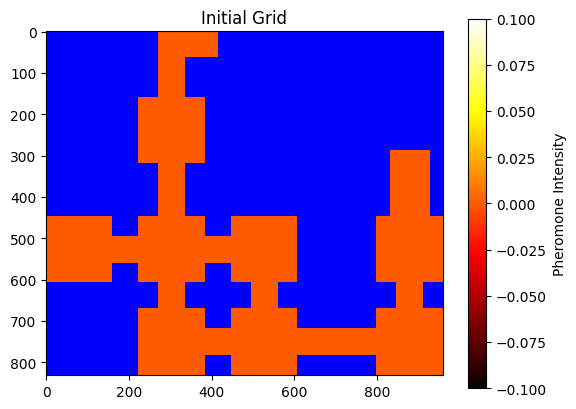

Iteration 1/200
Ant 0.0, tics: 2110, success: False
Path: [(303, 526), (303, 526), (303, 526), (304, 525), (305, 524), (306, 524), (307, 523), (308, 522), (308, 521), (308, 520), (309, 519), (310, 518), (310, 517), (311, 516), (312, 515), (313, 514), (314, 514), (315, 513), (316, 513), (317, 512), (318, 511), (319, 510), (320, 509), (321, 509), (322, 508), (323, 508), (324, 507), (325, 506), (326, 506), (327, 505), (328, 505), (329, 504), (330, 503), (330, 502), (331, 501), (332, 500), (332, 499), (333, 498), (334, 497), (334, 496), (335, 495), (336, 494), (337, 493), (338, 492), (339, 491), (340, 490), (341, 489), (342, 488), (343, 488), (344, 487), (345, 486), (346, 486), (347, 485), (348, 484), (348, 483), (349, 482), (350, 481), (351, 480), (352, 479), (352, 478), (353, 477), (354, 476), (355, 476), (356, 475), (357, 474), (358, 473), (359, 472), (360, 472), (361, 471), (362, 470), (362, 469), (363, 468), (364, 467), (364, 466), (364, 465), (365, 464), (365, 463), (366, 463), (366,

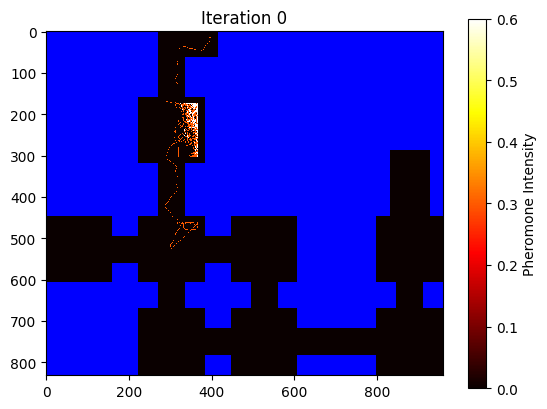

--------------------------------------------------
Spawn counts and success rates (for iteration 0):

Spawned far: 0/0
Spawned relatively close: 0/2
Spawned close: 0/0
Total spawn counts and success rates so far:
Total spawned far: 0/0
Total spawned relatively close: 0/2
Total spawned close: 0/0
--------------------------------------------------
Iteration 2/200
Ant 1.0, tics: 2110, success: False
Path: [(302, 527), (302, 526), (302, 525), (301, 525), (300, 524), (299, 523), (298, 522), (297, 521), (297, 520), (297, 519), (296, 518), (296, 517), (295, 516), (294, 516), (293, 515), (292, 515), (291, 514), (290, 513), (289, 512), (289, 511), (288, 510), (288, 509), (288, 508), (287, 507), (287, 506), (286, 505), (285, 504), (284, 503), (284, 502), (284, 501), (283, 500), (282, 499), (281, 498), (280, 497), (279, 496), (279, 495), (278, 494), (278, 493), (278, 492), (278, 491), (278, 490), (277, 489), (277, 488), (277, 487), (277, 486), (276, 486), (275, 485), (275, 484), (275, 483), (274,

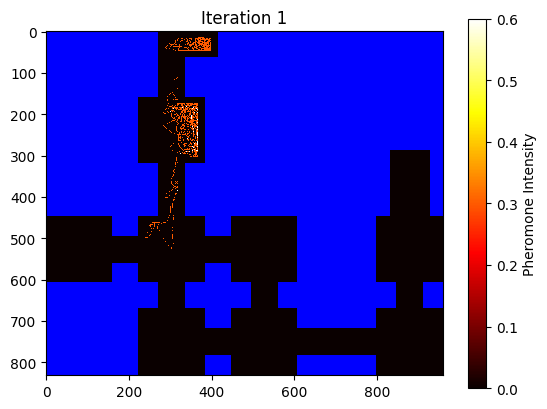

--------------------------------------------------
Spawn counts and success rates (for iteration 1):

Spawned far: 0/0
Spawned relatively close: 0/2
Spawned close: 0/0
Total spawn counts and success rates so far:
Total spawned far: 0/0
Total spawned relatively close: 0/4
Total spawned close: 0/0
--------------------------------------------------
Iteration 3/200
Ant 2.0, tics: 2110, success: False
Path: [(304, 527), (305, 526), (305, 526), (306, 526), (307, 526), (308, 527), (309, 527), (310, 527), (311, 527), (312, 528), (313, 528), (314, 528), (315, 528), (316, 528), (317, 528), (318, 527), (319, 526), (320, 525), (320, 524), (321, 523), (322, 522), (323, 521), (324, 520), (325, 519), (326, 518), (327, 518), (328, 517), (329, 516), (330, 516), (331, 515), (332, 514), (333, 513), (334, 512), (335, 511), (336, 510), (336, 509), (337, 508), (338, 507), (339, 506), (340, 505), (340, 504), (341, 503), (342, 502), (343, 502), (344, 502), (345, 501), (346, 501), (347, 501), (348, 501), (348,

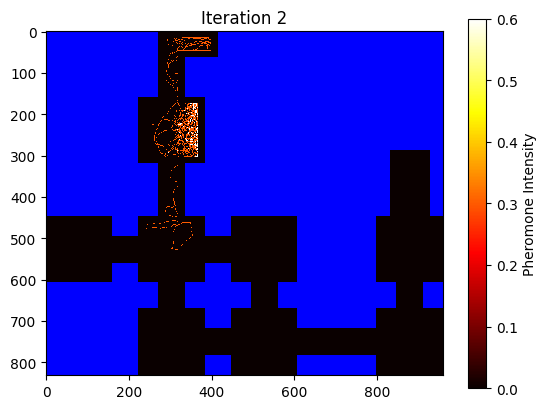

--------------------------------------------------
Spawn counts and success rates (for iteration 2):

Spawned far: 0/0
Spawned relatively close: 0/2
Spawned close: 0/0
Total spawn counts and success rates so far:
Total spawned far: 0/0
Total spawned relatively close: 0/6
Total spawned close: 0/0
--------------------------------------------------
Iteration 4/200
Ant 3.0, tics: 2110, success: False
Path: [(304, 527), (305, 526), (306, 525), (307, 525), (308, 525), (309, 525), (310, 525), (311, 525), (312, 525), (313, 525), (314, 526), (315, 526), (316, 527), (317, 528), (318, 529), (318, 530), (318, 531), (317, 532), (317, 532), (316, 532), (315, 532), (314, 532), (314, 531), (313, 530), (312, 529), (311, 528), (310, 528), (310, 527), (309, 526), (309, 525), (308, 524), (308, 523), (307, 522), (306, 521), (305, 520), (305, 519), (304, 518), (304, 517), (304, 516), (303, 515), (303, 514), (302, 513), (302, 512), (301, 511), (301, 510), (301, 509), (301, 508), (301, 507), (301, 506), (301,

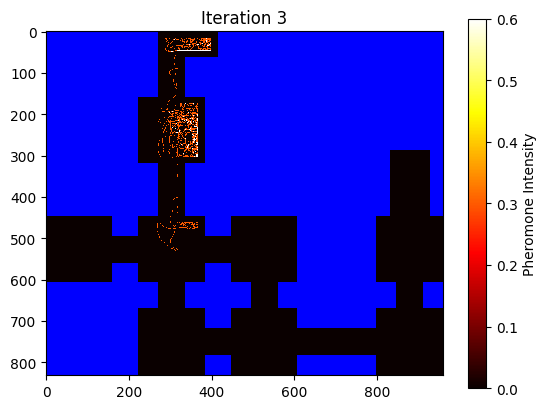

--------------------------------------------------
Spawn counts and success rates (for iteration 3):

Spawned far: 0/0
Spawned relatively close: 0/2
Spawned close: 0/0
Total spawn counts and success rates so far:
Total spawned far: 0/0
Total spawned relatively close: 0/8
Total spawned close: 0/0
--------------------------------------------------
Iteration 5/200
Ant 4.0, tics: 2110, success: False
Path: [(304, 527), (305, 526), (306, 525), (307, 525), (308, 524), (309, 523), (310, 522), (311, 522), (312, 521), (312, 520), (312, 519), (313, 518), (314, 518), (315, 517), (316, 516), (316, 515), (317, 514), (318, 513), (318, 512), (319, 511), (320, 510), (321, 509), (322, 509), (323, 508), (324, 507), (324, 506), (324, 505), (324, 504), (324, 503), (324, 502), (323, 501), (322, 500), (322, 499), (321, 498), (320, 497), (319, 496), (318, 495), (317, 494), (316, 493), (315, 492), (314, 492), (313, 491), (312, 491), (311, 490), (310, 489), (309, 489), (308, 488), (307, 488), (306, 487), (305,

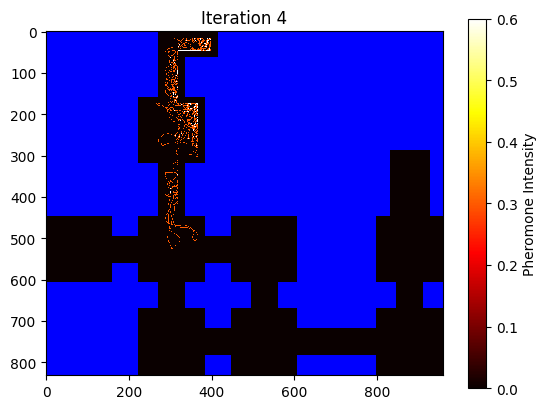

--------------------------------------------------
Spawn counts and success rates (for iteration 4):

Spawned far: 0/0
Spawned relatively close: 0/2
Spawned close: 0/0
Total spawn counts and success rates so far:
Total spawned far: 0/0
Total spawned relatively close: 0/10
Total spawned close: 0/0
--------------------------------------------------
Iteration 6/200
Ant 5.0, tics: 2110, success: False
Path: [(304, 527), (304, 527), (305, 527), (305, 526), (306, 525), (306, 524), (307, 523), (308, 523), (309, 523), (310, 524), (311, 524), (312, 524), (313, 523), (314, 522), (315, 522), (316, 521), (317, 521), (318, 520), (319, 520), (320, 520), (321, 519), (322, 519), (323, 519), (324, 519), (325, 519), (326, 519), (327, 519), (328, 519), (329, 519), (330, 518), (331, 518), (332, 518), (333, 518), (334, 517), (335, 517), (336, 516), (337, 516), (338, 516), (339, 515), (340, 515), (341, 514), (342, 513), (343, 512), (344, 511), (344, 510), (344, 509), (345, 508), (345, 507), (345, 506), (345

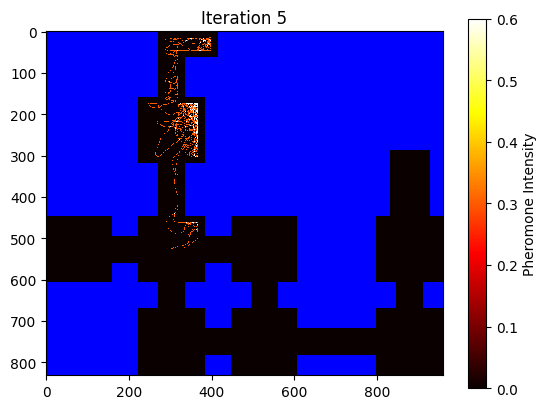

--------------------------------------------------
Spawn counts and success rates (for iteration 5):

Spawned far: 0/0
Spawned relatively close: 0/2
Spawned close: 0/0
Total spawn counts and success rates so far:
Total spawned far: 0/0
Total spawned relatively close: 0/12
Total spawned close: 0/0
--------------------------------------------------
Iteration 7/200
Ant 6.0, tics: 2110, success: False
Path: [(302, 527), (302, 527), (303, 526), (303, 525), (303, 524), (303, 523), (304, 522), (304, 521), (305, 520), (306, 520), (306, 519), (307, 518), (307, 517), (308, 516), (309, 515), (310, 514), (310, 513), (310, 512), (310, 511), (310, 510), (310, 509), (310, 508), (311, 507), (312, 506), (312, 505), (312, 504), (312, 503), (313, 502), (313, 501), (314, 500), (314, 499), (314, 498), (314, 497), (315, 496), (315, 495), (316, 494), (316, 493), (316, 492), (317, 491), (318, 490), (318, 489), (319, 488), (319, 487), (319, 486), (319, 485), (319, 484), (320, 483), (320, 482), (320, 481), (320

KeyboardInterrupt: 

In [ ]:
#Initialize the environment and run ACO training

env = mywayhome_VZG(config_path=doomfinder("my_way_home_nodes.cfg"), pheromone_evaporation_rate=1.0, render=False, frameskip=1) #Lower frameskip makes better maps but takes longer
#env = mywayhome_VZG(config_path=doomfinder("my_way_home_4_dir.cfg"), pheromone_evaporation_rate=0.5, render=True, frameskip=4) #Lower frameskip makes better maps but takes longer

#Create run directory
run_dir, log_dir, maps_dir = create_run_directory()

if saved_pheromone_grid is not None:
        env.pheromone_map = saved_pheromone_grid
else:
    env.pheromone_map = get_starting_grid()

aco_training(env, num_ants = 50, iterations=200, unsuccessful_deposit=0.3, pheromone_deposit = 20.0, run_dir=run_dir, log_dir=log_dir, maps_dir=maps_dir, alpha = 0.7, beta = 0.3, log_image_rate = 25) #Run ACO training


Test Pheromone Map

In [ ]:
#Initialize the environment for testing
#env = mywayhome_VZG(config_path=doomfinder("my_way_home_4_dir.cfg"), pheromone_evaporation_rate=0, render=True, frameskip=4) 
env = mywayhome_VZG(config_path=doomfinder("my_way_home_nodes.cfg"), pheromone_evaporation_rate=0, render=True, frameskip=4) 

#Run the test function
test_saved_maps(env=env, num_tests=5, pheromone_grid=saved_pheromone_grid, alpha = 0.8, beta = 0.2, automap_enabled=False) #Test the saved pheromone maps